# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [92]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

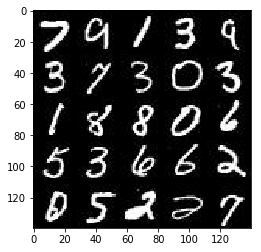

In [93]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

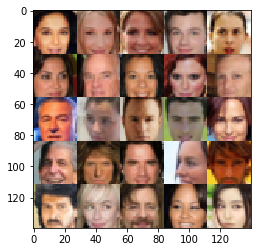

In [94]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [95]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [96]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [105]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):

        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)

        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [106]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*512)

        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)

        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
       
        out = tf.tanh(logits) 
   
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [99]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * 0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [107]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [108]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [109]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    tf.reset_default_graph()

    images_count, image_width, image_height, image_channels = data_shape
    
    input_real, input_z, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})

                if steps % 10 == 0:
                    # Get the losses and print them out after each 10 steps
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 7.8207... Generator Loss: 0.6754
Epoch 1/2... Discriminator Loss: 0.7279... Generator Loss: 3.7275
Epoch 1/2... Discriminator Loss: 1.9653... Generator Loss: 0.3815
Epoch 1/2... Discriminator Loss: 2.0212... Generator Loss: 0.3386
Epoch 1/2... Discriminator Loss: 1.3697... Generator Loss: 0.5933
Epoch 1/2... Discriminator Loss: 1.5658... Generator Loss: 0.4307
Epoch 1/2... Discriminator Loss: 2.2350... Generator Loss: 0.2018
Epoch 1/2... Discriminator Loss: 1.9791... Generator Loss: 0.2705
Epoch 1/2... Discriminator Loss: 1.2355... Generator Loss: 0.6049
Epoch 1/2... Discriminator Loss: 1.0867... Generator Loss: 0.7768


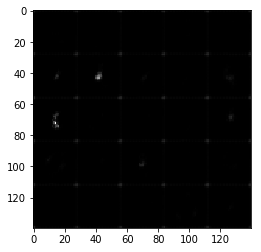

Epoch 1/2... Discriminator Loss: 0.3572... Generator Loss: 4.3449
Epoch 1/2... Discriminator Loss: 1.0359... Generator Loss: 0.8830
Epoch 1/2... Discriminator Loss: 1.2569... Generator Loss: 0.6115
Epoch 1/2... Discriminator Loss: 0.4912... Generator Loss: 3.2234
Epoch 1/2... Discriminator Loss: 0.4157... Generator Loss: 3.0770
Epoch 1/2... Discriminator Loss: 0.3754... Generator Loss: 3.8286
Epoch 1/2... Discriminator Loss: 0.5197... Generator Loss: 2.5965
Epoch 1/2... Discriminator Loss: 0.4949... Generator Loss: 2.3329
Epoch 1/2... Discriminator Loss: 0.5362... Generator Loss: 4.4495
Epoch 1/2... Discriminator Loss: 0.3920... Generator Loss: 3.2559


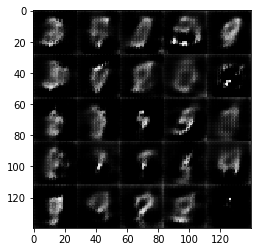

Epoch 1/2... Discriminator Loss: 0.5756... Generator Loss: 2.4746
Epoch 1/2... Discriminator Loss: 0.3825... Generator Loss: 3.3168
Epoch 1/2... Discriminator Loss: 0.3346... Generator Loss: 5.9846
Epoch 1/2... Discriminator Loss: 0.3539... Generator Loss: 4.3807
Epoch 1/2... Discriminator Loss: 0.7316... Generator Loss: 1.3663
Epoch 1/2... Discriminator Loss: 0.4879... Generator Loss: 2.4344
Epoch 1/2... Discriminator Loss: 1.8078... Generator Loss: 0.2851
Epoch 1/2... Discriminator Loss: 1.4442... Generator Loss: 0.5755
Epoch 1/2... Discriminator Loss: 1.3271... Generator Loss: 0.5346
Epoch 1/2... Discriminator Loss: 1.2167... Generator Loss: 0.6005


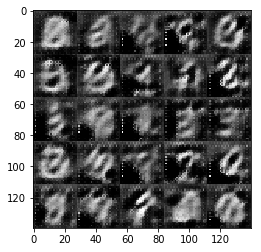

Epoch 1/2... Discriminator Loss: 0.8314... Generator Loss: 1.1184
Epoch 1/2... Discriminator Loss: 0.8444... Generator Loss: 1.0150
Epoch 1/2... Discriminator Loss: 0.9405... Generator Loss: 0.9277
Epoch 1/2... Discriminator Loss: 1.0921... Generator Loss: 3.4636
Epoch 1/2... Discriminator Loss: 0.5601... Generator Loss: 2.3364
Epoch 1/2... Discriminator Loss: 0.6132... Generator Loss: 2.1486
Epoch 1/2... Discriminator Loss: 0.4537... Generator Loss: 2.7971
Epoch 1/2... Discriminator Loss: 1.0853... Generator Loss: 1.4928
Epoch 1/2... Discriminator Loss: 0.3782... Generator Loss: 4.1886
Epoch 1/2... Discriminator Loss: 0.6002... Generator Loss: 1.9663


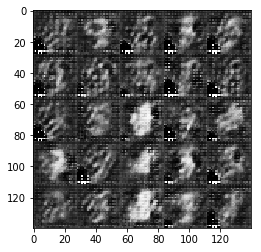

Epoch 1/2... Discriminator Loss: 1.0114... Generator Loss: 0.9022
Epoch 1/2... Discriminator Loss: 0.5576... Generator Loss: 2.6787
Epoch 1/2... Discriminator Loss: 0.5217... Generator Loss: 2.9598
Epoch 1/2... Discriminator Loss: 0.3695... Generator Loss: 4.6332
Epoch 1/2... Discriminator Loss: 0.3587... Generator Loss: 5.2381
Epoch 1/2... Discriminator Loss: 0.4317... Generator Loss: 3.8940
Epoch 1/2... Discriminator Loss: 0.5181... Generator Loss: 3.3681
Epoch 1/2... Discriminator Loss: 0.3511... Generator Loss: 5.2669
Epoch 1/2... Discriminator Loss: 1.8645... Generator Loss: 1.2905
Epoch 1/2... Discriminator Loss: 0.7725... Generator Loss: 1.4476


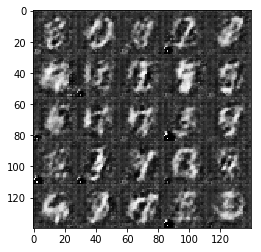

Epoch 1/2... Discriminator Loss: 0.8584... Generator Loss: 1.4235
Epoch 1/2... Discriminator Loss: 0.3958... Generator Loss: 5.4084
Epoch 1/2... Discriminator Loss: 0.3950... Generator Loss: 4.1058
Epoch 1/2... Discriminator Loss: 0.4067... Generator Loss: 4.0188
Epoch 1/2... Discriminator Loss: 0.3592... Generator Loss: 4.4936
Epoch 1/2... Discriminator Loss: 0.3862... Generator Loss: 4.2493
Epoch 1/2... Discriminator Loss: 0.3802... Generator Loss: 4.0354
Epoch 1/2... Discriminator Loss: 0.3660... Generator Loss: 6.1217
Epoch 1/2... Discriminator Loss: 0.3405... Generator Loss: 5.4578
Epoch 1/2... Discriminator Loss: 0.3842... Generator Loss: 3.9961


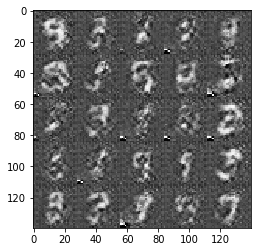

Epoch 1/2... Discriminator Loss: 1.0707... Generator Loss: 1.1210
Epoch 1/2... Discriminator Loss: 0.5223... Generator Loss: 3.4689
Epoch 1/2... Discriminator Loss: 0.4102... Generator Loss: 3.6894
Epoch 1/2... Discriminator Loss: 3.2677... Generator Loss: 0.1175
Epoch 1/2... Discriminator Loss: 1.6818... Generator Loss: 0.4966
Epoch 1/2... Discriminator Loss: 0.6140... Generator Loss: 2.4753
Epoch 1/2... Discriminator Loss: 0.4195... Generator Loss: 3.7673
Epoch 1/2... Discriminator Loss: 0.3628... Generator Loss: 4.2997
Epoch 1/2... Discriminator Loss: 0.3794... Generator Loss: 4.0776
Epoch 1/2... Discriminator Loss: 0.3513... Generator Loss: 5.3490


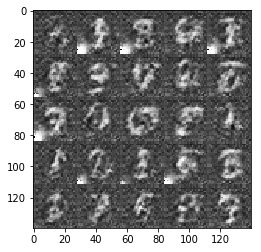

Epoch 1/2... Discriminator Loss: 0.3550... Generator Loss: 4.6902
Epoch 1/2... Discriminator Loss: 0.3397... Generator Loss: 5.1559
Epoch 1/2... Discriminator Loss: 0.3310... Generator Loss: 7.0720
Epoch 1/2... Discriminator Loss: 0.3776... Generator Loss: 4.7924
Epoch 1/2... Discriminator Loss: 0.3536... Generator Loss: 4.8541
Epoch 1/2... Discriminator Loss: 0.5318... Generator Loss: 2.5779
Epoch 1/2... Discriminator Loss: 0.3456... Generator Loss: 6.0118
Epoch 1/2... Discriminator Loss: 0.3352... Generator Loss: 7.9847
Epoch 1/2... Discriminator Loss: 0.3457... Generator Loss: 5.2104
Epoch 1/2... Discriminator Loss: 0.4015... Generator Loss: 3.4087


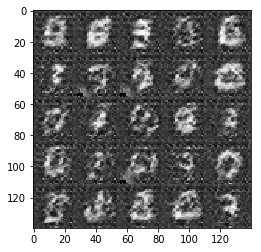

Epoch 1/2... Discriminator Loss: 0.3311... Generator Loss: 8.7455
Epoch 1/2... Discriminator Loss: 0.3777... Generator Loss: 4.4619
Epoch 1/2... Discriminator Loss: 0.3439... Generator Loss: 5.1831
Epoch 1/2... Discriminator Loss: 0.3853... Generator Loss: 5.4089
Epoch 1/2... Discriminator Loss: 0.3482... Generator Loss: 5.2195
Epoch 1/2... Discriminator Loss: 0.3662... Generator Loss: 4.4358
Epoch 1/2... Discriminator Loss: 0.3556... Generator Loss: 4.9484
Epoch 1/2... Discriminator Loss: 0.3464... Generator Loss: 4.9432
Epoch 1/2... Discriminator Loss: 0.3373... Generator Loss: 5.7453
Epoch 1/2... Discriminator Loss: 0.3634... Generator Loss: 4.7008


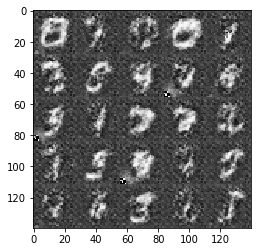

Epoch 1/2... Discriminator Loss: 0.3472... Generator Loss: 4.6745
Epoch 1/2... Discriminator Loss: 0.3295... Generator Loss: 7.2287
Epoch 1/2... Discriminator Loss: 0.3324... Generator Loss: 9.1480
Epoch 2/2... Discriminator Loss: 0.3341... Generator Loss: 5.5620
Epoch 2/2... Discriminator Loss: 2.7075... Generator Loss: 0.1935
Epoch 2/2... Discriminator Loss: 1.6186... Generator Loss: 0.6895
Epoch 2/2... Discriminator Loss: 1.7053... Generator Loss: 1.5569
Epoch 2/2... Discriminator Loss: 1.7460... Generator Loss: 2.5418
Epoch 2/2... Discriminator Loss: 1.6146... Generator Loss: 2.2922
Epoch 2/2... Discriminator Loss: 1.2113... Generator Loss: 1.4566


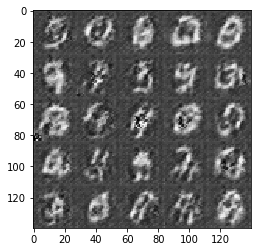

Epoch 2/2... Discriminator Loss: 1.6037... Generator Loss: 2.1993
Epoch 2/2... Discriminator Loss: 1.9671... Generator Loss: 2.3696
Epoch 2/2... Discriminator Loss: 1.3678... Generator Loss: 1.8915
Epoch 2/2... Discriminator Loss: 1.7058... Generator Loss: 2.2392
Epoch 2/2... Discriminator Loss: 2.0525... Generator Loss: 3.2878
Epoch 2/2... Discriminator Loss: 1.1454... Generator Loss: 0.6682
Epoch 2/2... Discriminator Loss: 1.1566... Generator Loss: 0.6751
Epoch 2/2... Discriminator Loss: 0.9268... Generator Loss: 0.8981
Epoch 2/2... Discriminator Loss: 1.2857... Generator Loss: 0.5641
Epoch 2/2... Discriminator Loss: 1.7104... Generator Loss: 2.0953


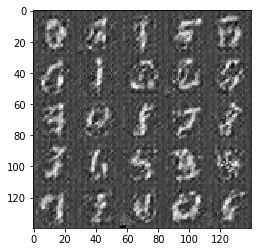

Epoch 2/2... Discriminator Loss: 1.0601... Generator Loss: 1.2929
Epoch 2/2... Discriminator Loss: 1.2112... Generator Loss: 1.2182
Epoch 2/2... Discriminator Loss: 2.4206... Generator Loss: 3.3617
Epoch 2/2... Discriminator Loss: 0.7317... Generator Loss: 2.6643
Epoch 2/2... Discriminator Loss: 0.7164... Generator Loss: 1.4794
Epoch 2/2... Discriminator Loss: 0.3707... Generator Loss: 3.7671
Epoch 2/2... Discriminator Loss: 0.3602... Generator Loss: 4.1829
Epoch 2/2... Discriminator Loss: 0.3748... Generator Loss: 3.8847
Epoch 2/2... Discriminator Loss: 0.5689... Generator Loss: 1.8785
Epoch 2/2... Discriminator Loss: 0.6011... Generator Loss: 1.5806


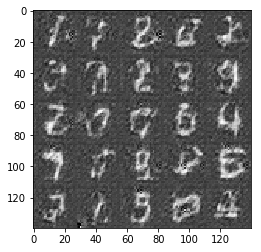

Epoch 2/2... Discriminator Loss: 0.3499... Generator Loss: 4.2603
Epoch 2/2... Discriminator Loss: 0.6766... Generator Loss: 1.3769
Epoch 2/2... Discriminator Loss: 1.4672... Generator Loss: 0.8678
Epoch 2/2... Discriminator Loss: 0.8391... Generator Loss: 1.0958
Epoch 2/2... Discriminator Loss: 1.2071... Generator Loss: 0.6357
Epoch 2/2... Discriminator Loss: 0.5939... Generator Loss: 1.6242
Epoch 2/2... Discriminator Loss: 0.5939... Generator Loss: 1.5870
Epoch 2/2... Discriminator Loss: 0.3991... Generator Loss: 2.9691
Epoch 2/2... Discriminator Loss: 0.4376... Generator Loss: 2.5915
Epoch 2/2... Discriminator Loss: 0.5635... Generator Loss: 2.3800


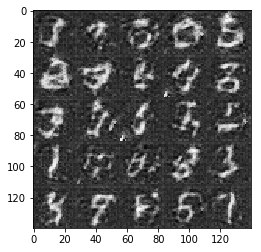

Epoch 2/2... Discriminator Loss: 1.8610... Generator Loss: 0.2974
Epoch 2/2... Discriminator Loss: 1.4786... Generator Loss: 0.4356
Epoch 2/2... Discriminator Loss: 0.9105... Generator Loss: 0.9506
Epoch 2/2... Discriminator Loss: 0.6921... Generator Loss: 1.3259
Epoch 2/2... Discriminator Loss: 0.6681... Generator Loss: 1.4089
Epoch 2/2... Discriminator Loss: 1.5284... Generator Loss: 0.4745
Epoch 2/2... Discriminator Loss: 0.4896... Generator Loss: 3.3310
Epoch 2/2... Discriminator Loss: 2.7511... Generator Loss: 0.1442
Epoch 2/2... Discriminator Loss: 0.5071... Generator Loss: 2.1086
Epoch 2/2... Discriminator Loss: 0.4021... Generator Loss: 4.2213


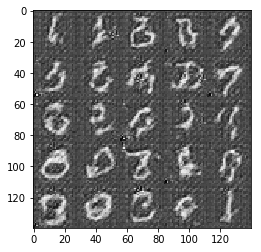

Epoch 2/2... Discriminator Loss: 0.4411... Generator Loss: 2.4520
Epoch 2/2... Discriminator Loss: 0.3810... Generator Loss: 4.1348
Epoch 2/2... Discriminator Loss: 0.3498... Generator Loss: 4.6156
Epoch 2/2... Discriminator Loss: 0.3448... Generator Loss: 4.8001
Epoch 2/2... Discriminator Loss: 0.3535... Generator Loss: 4.0821
Epoch 2/2... Discriminator Loss: 0.3417... Generator Loss: 4.8017
Epoch 2/2... Discriminator Loss: 0.3382... Generator Loss: 6.1406
Epoch 2/2... Discriminator Loss: 1.2804... Generator Loss: 0.6776
Epoch 2/2... Discriminator Loss: 0.9475... Generator Loss: 0.8756
Epoch 2/2... Discriminator Loss: 0.3875... Generator Loss: 3.2438


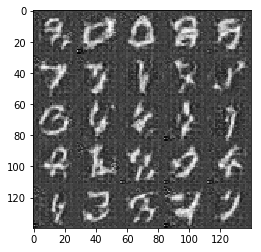

Epoch 2/2... Discriminator Loss: 0.7952... Generator Loss: 1.1536
Epoch 2/2... Discriminator Loss: 1.6585... Generator Loss: 0.6169
Epoch 2/2... Discriminator Loss: 1.0120... Generator Loss: 2.5074
Epoch 2/2... Discriminator Loss: 0.3658... Generator Loss: 4.0949
Epoch 2/2... Discriminator Loss: 0.3562... Generator Loss: 3.8512
Epoch 2/2... Discriminator Loss: 1.0334... Generator Loss: 2.1592
Epoch 2/2... Discriminator Loss: 0.4118... Generator Loss: 2.8304
Epoch 2/2... Discriminator Loss: 0.6262... Generator Loss: 1.6054
Epoch 2/2... Discriminator Loss: 0.9705... Generator Loss: 0.8552
Epoch 2/2... Discriminator Loss: 1.7647... Generator Loss: 0.4153


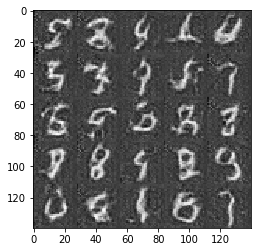

Epoch 2/2... Discriminator Loss: 0.4545... Generator Loss: 2.3074
Epoch 2/2... Discriminator Loss: 0.4334... Generator Loss: 3.9661
Epoch 2/2... Discriminator Loss: 0.3699... Generator Loss: 3.5900
Epoch 2/2... Discriminator Loss: 0.6937... Generator Loss: 1.3285
Epoch 2/2... Discriminator Loss: 2.7489... Generator Loss: 0.1453
Epoch 2/2... Discriminator Loss: 0.9442... Generator Loss: 0.8925
Epoch 2/2... Discriminator Loss: 0.3799... Generator Loss: 3.4754
Epoch 2/2... Discriminator Loss: 1.9297... Generator Loss: 3.1488
Epoch 2/2... Discriminator Loss: 0.5371... Generator Loss: 1.9784
Epoch 2/2... Discriminator Loss: 0.6366... Generator Loss: 1.6208


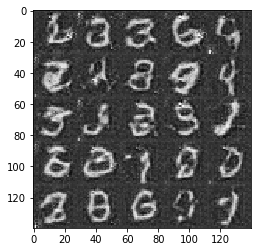

Epoch 2/2... Discriminator Loss: 0.4995... Generator Loss: 2.0088
Epoch 2/2... Discriminator Loss: 0.4300... Generator Loss: 2.5408
Epoch 2/2... Discriminator Loss: 0.4046... Generator Loss: 2.7686
Epoch 2/2... Discriminator Loss: 0.3784... Generator Loss: 6.2568
Epoch 2/2... Discriminator Loss: 0.4349... Generator Loss: 2.5016
Epoch 2/2... Discriminator Loss: 0.5046... Generator Loss: 3.4425
Epoch 2/2... Discriminator Loss: 0.6623... Generator Loss: 1.3980
Epoch 2/2... Discriminator Loss: 0.3462... Generator Loss: 4.6514
Epoch 2/2... Discriminator Loss: 0.3399... Generator Loss: 5.1063
Epoch 2/2... Discriminator Loss: 0.6146... Generator Loss: 5.7862


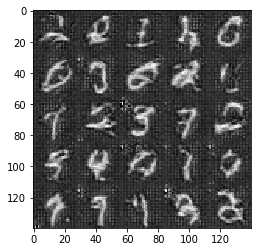

Epoch 2/2... Discriminator Loss: 1.6928... Generator Loss: 2.9696
Epoch 2/2... Discriminator Loss: 0.5915... Generator Loss: 1.6839
Epoch 2/2... Discriminator Loss: 1.4919... Generator Loss: 0.4491
Epoch 2/2... Discriminator Loss: 0.7751... Generator Loss: 1.2382
Epoch 2/2... Discriminator Loss: 1.1564... Generator Loss: 0.7650
Epoch 2/2... Discriminator Loss: 1.4511... Generator Loss: 0.6022
Epoch 2/2... Discriminator Loss: 0.5116... Generator Loss: 3.0158


IndexError: list index out of range

In [110]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.9211... Generator Loss: 12.7657
Epoch 1/1... Discriminator Loss: 0.3832... Generator Loss: 6.8918
Epoch 1/1... Discriminator Loss: 0.3546... Generator Loss: 5.1952
Epoch 1/1... Discriminator Loss: 0.3461... Generator Loss: 6.5185
Epoch 1/1... Discriminator Loss: 0.8410... Generator Loss: 1.8204
Epoch 1/1... Discriminator Loss: 0.4591... Generator Loss: 2.7329
Epoch 1/1... Discriminator Loss: 0.6432... Generator Loss: 2.0301
Epoch 1/1... Discriminator Loss: 0.5910... Generator Loss: 1.8890
Epoch 1/1... Discriminator Loss: 0.6380... Generator Loss: 3.4250
Epoch 1/1... Discriminator Loss: 0.4200... Generator Loss: 3.5157


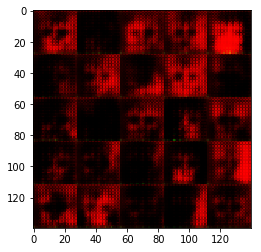

Epoch 1/1... Discriminator Loss: 0.3963... Generator Loss: 3.8714
Epoch 1/1... Discriminator Loss: 0.4243... Generator Loss: 2.8764
Epoch 1/1... Discriminator Loss: 0.3508... Generator Loss: 4.8099
Epoch 1/1... Discriminator Loss: 0.4210... Generator Loss: 2.6823
Epoch 1/1... Discriminator Loss: 2.1812... Generator Loss: 5.7252
Epoch 1/1... Discriminator Loss: 0.4121... Generator Loss: 3.3239
Epoch 1/1... Discriminator Loss: 0.3510... Generator Loss: 4.5533
Epoch 1/1... Discriminator Loss: 0.3904... Generator Loss: 3.6042
Epoch 1/1... Discriminator Loss: 0.9710... Generator Loss: 0.9655
Epoch 1/1... Discriminator Loss: 0.4402... Generator Loss: 3.6847


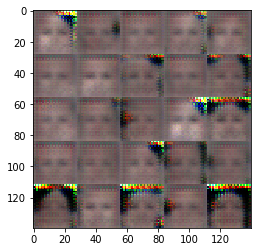

Epoch 1/1... Discriminator Loss: 1.0814... Generator Loss: 0.8108
Epoch 1/1... Discriminator Loss: 0.5452... Generator Loss: 3.0546
Epoch 1/1... Discriminator Loss: 0.4521... Generator Loss: 2.8227
Epoch 1/1... Discriminator Loss: 0.4028... Generator Loss: 3.4182
Epoch 1/1... Discriminator Loss: 0.3653... Generator Loss: 4.3641
Epoch 1/1... Discriminator Loss: 0.4656... Generator Loss: 3.7225
Epoch 1/1... Discriminator Loss: 0.5317... Generator Loss: 2.4040
Epoch 1/1... Discriminator Loss: 0.3816... Generator Loss: 4.5084
Epoch 1/1... Discriminator Loss: 1.4582... Generator Loss: 1.6337
Epoch 1/1... Discriminator Loss: 0.5804... Generator Loss: 1.9292


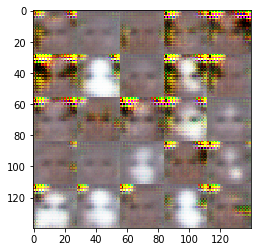

Epoch 1/1... Discriminator Loss: 0.4056... Generator Loss: 3.5064
Epoch 1/1... Discriminator Loss: 0.3796... Generator Loss: 3.8789
Epoch 1/1... Discriminator Loss: 0.4717... Generator Loss: 2.7038
Epoch 1/1... Discriminator Loss: 0.4437... Generator Loss: 3.5510
Epoch 1/1... Discriminator Loss: 0.6478... Generator Loss: 2.2350
Epoch 1/1... Discriminator Loss: 1.2746... Generator Loss: 0.7846
Epoch 1/1... Discriminator Loss: 1.2887... Generator Loss: 0.9035
Epoch 1/1... Discriminator Loss: 1.0919... Generator Loss: 0.9812
Epoch 1/1... Discriminator Loss: 1.1883... Generator Loss: 0.8003
Epoch 1/1... Discriminator Loss: 1.2657... Generator Loss: 0.9717


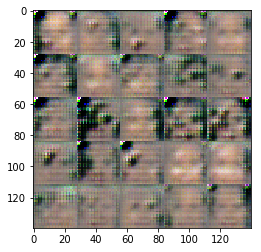

Epoch 1/1... Discriminator Loss: 0.9514... Generator Loss: 1.6176
Epoch 1/1... Discriminator Loss: 0.7629... Generator Loss: 1.7044
Epoch 1/1... Discriminator Loss: 1.5576... Generator Loss: 0.5119
Epoch 1/1... Discriminator Loss: 1.7481... Generator Loss: 0.8316
Epoch 1/1... Discriminator Loss: 1.3064... Generator Loss: 1.0589
Epoch 1/1... Discriminator Loss: 1.1460... Generator Loss: 1.1612
Epoch 1/1... Discriminator Loss: 0.6704... Generator Loss: 1.5281
Epoch 1/1... Discriminator Loss: 0.5611... Generator Loss: 2.7114
Epoch 1/1... Discriminator Loss: 0.6321... Generator Loss: 2.8398
Epoch 1/1... Discriminator Loss: 0.4609... Generator Loss: 4.2065


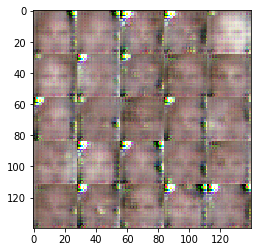

Epoch 1/1... Discriminator Loss: 1.2778... Generator Loss: 2.4421
Epoch 1/1... Discriminator Loss: 0.6059... Generator Loss: 2.0620
Epoch 1/1... Discriminator Loss: 2.0873... Generator Loss: 3.3504
Epoch 1/1... Discriminator Loss: 0.7554... Generator Loss: 1.8828
Epoch 1/1... Discriminator Loss: 1.5122... Generator Loss: 4.0175
Epoch 1/1... Discriminator Loss: 0.7820... Generator Loss: 1.6078
Epoch 1/1... Discriminator Loss: 1.4775... Generator Loss: 0.4692
Epoch 1/1... Discriminator Loss: 0.5521... Generator Loss: 2.4415
Epoch 1/1... Discriminator Loss: 0.4789... Generator Loss: 2.4977
Epoch 1/1... Discriminator Loss: 0.4253... Generator Loss: 3.3677


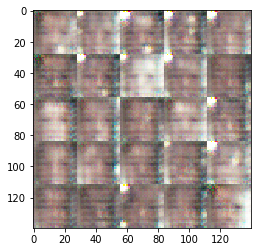

Epoch 1/1... Discriminator Loss: 0.4826... Generator Loss: 3.1005
Epoch 1/1... Discriminator Loss: 0.4537... Generator Loss: 3.2465
Epoch 1/1... Discriminator Loss: 0.4072... Generator Loss: 4.1266
Epoch 1/1... Discriminator Loss: 0.4815... Generator Loss: 3.8161
Epoch 1/1... Discriminator Loss: 0.4403... Generator Loss: 2.9172
Epoch 1/1... Discriminator Loss: 0.3733... Generator Loss: 4.5723
Epoch 1/1... Discriminator Loss: 0.4266... Generator Loss: 3.4522
Epoch 1/1... Discriminator Loss: 0.3711... Generator Loss: 4.7997
Epoch 1/1... Discriminator Loss: 0.3633... Generator Loss: 4.5663
Epoch 1/1... Discriminator Loss: 0.3466... Generator Loss: 4.8849


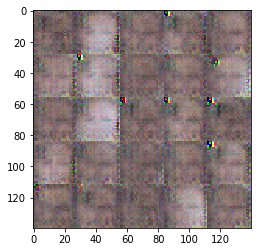

Epoch 1/1... Discriminator Loss: 0.3520... Generator Loss: 4.6454
Epoch 1/1... Discriminator Loss: 0.4465... Generator Loss: 3.1706
Epoch 1/1... Discriminator Loss: 0.7145... Generator Loss: 1.4501
Epoch 1/1... Discriminator Loss: 0.7054... Generator Loss: 1.8083
Epoch 1/1... Discriminator Loss: 0.6430... Generator Loss: 2.3319
Epoch 1/1... Discriminator Loss: 0.4525... Generator Loss: 2.9444
Epoch 1/1... Discriminator Loss: 0.3941... Generator Loss: 3.4218
Epoch 1/1... Discriminator Loss: 0.3640... Generator Loss: 4.1366
Epoch 1/1... Discriminator Loss: 0.4934... Generator Loss: 3.4225
Epoch 1/1... Discriminator Loss: 0.4683... Generator Loss: 2.7123


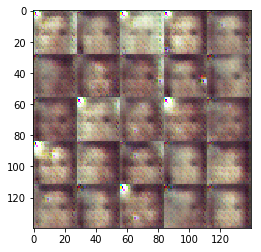

Epoch 1/1... Discriminator Loss: 0.3928... Generator Loss: 3.2759
Epoch 1/1... Discriminator Loss: 1.1571... Generator Loss: 0.7265
Epoch 1/1... Discriminator Loss: 0.8360... Generator Loss: 3.3105
Epoch 1/1... Discriminator Loss: 0.4137... Generator Loss: 3.7572
Epoch 1/1... Discriminator Loss: 0.3610... Generator Loss: 5.5286
Epoch 1/1... Discriminator Loss: 0.5127... Generator Loss: 2.3982
Epoch 1/1... Discriminator Loss: 0.5037... Generator Loss: 2.0218
Epoch 1/1... Discriminator Loss: 0.3543... Generator Loss: 4.5146
Epoch 1/1... Discriminator Loss: 0.4943... Generator Loss: 3.3127
Epoch 1/1... Discriminator Loss: 0.6926... Generator Loss: 2.0060


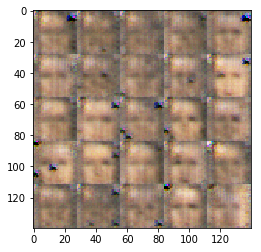

Epoch 1/1... Discriminator Loss: 0.7524... Generator Loss: 1.2584
Epoch 1/1... Discriminator Loss: 2.3421... Generator Loss: 1.9342
Epoch 1/1... Discriminator Loss: 1.4547... Generator Loss: 0.8743
Epoch 1/1... Discriminator Loss: 1.4994... Generator Loss: 0.7919
Epoch 1/1... Discriminator Loss: 1.5575... Generator Loss: 0.7387
Epoch 1/1... Discriminator Loss: 1.2716... Generator Loss: 0.8714
Epoch 1/1... Discriminator Loss: 1.2724... Generator Loss: 0.8610
Epoch 1/1... Discriminator Loss: 1.3543... Generator Loss: 0.9424
Epoch 1/1... Discriminator Loss: 1.4510... Generator Loss: 0.9159
Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.8605


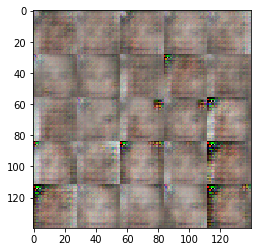

Epoch 1/1... Discriminator Loss: 1.7262... Generator Loss: 2.3488
Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 1.9340
Epoch 1/1... Discriminator Loss: 1.2763... Generator Loss: 0.7258
Epoch 1/1... Discriminator Loss: 0.9654... Generator Loss: 0.8638
Epoch 1/1... Discriminator Loss: 0.6279... Generator Loss: 1.7271
Epoch 1/1... Discriminator Loss: 0.6344... Generator Loss: 1.5454
Epoch 1/1... Discriminator Loss: 0.5061... Generator Loss: 2.1792
Epoch 1/1... Discriminator Loss: 0.7562... Generator Loss: 1.2916
Epoch 1/1... Discriminator Loss: 0.8691... Generator Loss: 1.6181
Epoch 1/1... Discriminator Loss: 0.3815... Generator Loss: 3.4922


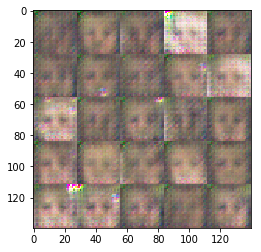

Epoch 1/1... Discriminator Loss: 0.4272... Generator Loss: 2.7505
Epoch 1/1... Discriminator Loss: 0.3864... Generator Loss: 3.3319
Epoch 1/1... Discriminator Loss: 0.3866... Generator Loss: 3.5968
Epoch 1/1... Discriminator Loss: 0.5005... Generator Loss: 2.5975
Epoch 1/1... Discriminator Loss: 2.0004... Generator Loss: 2.2574
Epoch 1/1... Discriminator Loss: 0.5005... Generator Loss: 2.1604
Epoch 1/1... Discriminator Loss: 0.4062... Generator Loss: 2.9196
Epoch 1/1... Discriminator Loss: 2.4618... Generator Loss: 0.8833
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 1.9806
Epoch 1/1... Discriminator Loss: 0.9102... Generator Loss: 1.5760


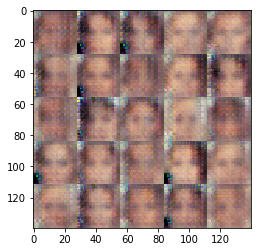

Epoch 1/1... Discriminator Loss: 0.5387... Generator Loss: 2.3327
Epoch 1/1... Discriminator Loss: 0.4350... Generator Loss: 2.5698
Epoch 1/1... Discriminator Loss: 0.5023... Generator Loss: 2.4069
Epoch 1/1... Discriminator Loss: 0.3631... Generator Loss: 4.0455
Epoch 1/1... Discriminator Loss: 0.9783... Generator Loss: 3.5570
Epoch 1/1... Discriminator Loss: 0.6293... Generator Loss: 2.1605
Epoch 1/1... Discriminator Loss: 1.5714... Generator Loss: 0.7523
Epoch 1/1... Discriminator Loss: 1.1183... Generator Loss: 0.7748
Epoch 1/1... Discriminator Loss: 1.6603... Generator Loss: 0.3855
Epoch 1/1... Discriminator Loss: 5.2512... Generator Loss: 5.6168


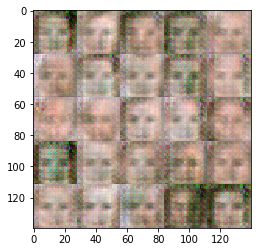

Epoch 1/1... Discriminator Loss: 1.8898... Generator Loss: 0.3778
Epoch 1/1... Discriminator Loss: 1.2561... Generator Loss: 0.9928
Epoch 1/1... Discriminator Loss: 1.4302... Generator Loss: 0.8355
Epoch 1/1... Discriminator Loss: 1.5564... Generator Loss: 0.6282
Epoch 1/1... Discriminator Loss: 1.0984... Generator Loss: 0.9431
Epoch 1/1... Discriminator Loss: 1.5427... Generator Loss: 0.8240
Epoch 1/1... Discriminator Loss: 1.4615... Generator Loss: 0.9376
Epoch 1/1... Discriminator Loss: 1.3260... Generator Loss: 0.7620
Epoch 1/1... Discriminator Loss: 1.6258... Generator Loss: 1.1541
Epoch 1/1... Discriminator Loss: 1.1752... Generator Loss: 1.0183


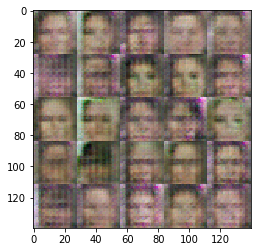

Epoch 1/1... Discriminator Loss: 1.3061... Generator Loss: 0.8065
Epoch 1/1... Discriminator Loss: 1.4435... Generator Loss: 0.6966
Epoch 1/1... Discriminator Loss: 1.2744... Generator Loss: 0.9205
Epoch 1/1... Discriminator Loss: 1.4403... Generator Loss: 0.6655
Epoch 1/1... Discriminator Loss: 1.5140... Generator Loss: 1.0404
Epoch 1/1... Discriminator Loss: 1.2014... Generator Loss: 1.0282
Epoch 1/1... Discriminator Loss: 1.0720... Generator Loss: 1.0137
Epoch 1/1... Discriminator Loss: 1.3697... Generator Loss: 0.7603
Epoch 1/1... Discriminator Loss: 1.5299... Generator Loss: 0.6747
Epoch 1/1... Discriminator Loss: 1.2803... Generator Loss: 0.6413


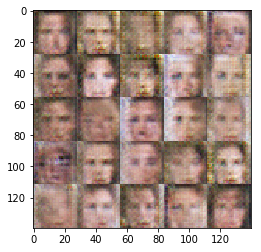

Epoch 1/1... Discriminator Loss: 1.2881... Generator Loss: 1.0941
Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.7815
Epoch 1/1... Discriminator Loss: 1.4833... Generator Loss: 0.6274
Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 1.4092
Epoch 1/1... Discriminator Loss: 1.4711... Generator Loss: 0.6497
Epoch 1/1... Discriminator Loss: 1.4788... Generator Loss: 0.9706
Epoch 1/1... Discriminator Loss: 1.2263... Generator Loss: 0.8379
Epoch 1/1... Discriminator Loss: 1.3143... Generator Loss: 1.1004
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.7638
Epoch 1/1... Discriminator Loss: 1.3853... Generator Loss: 0.9546


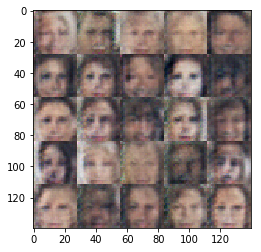

Epoch 1/1... Discriminator Loss: 1.5724... Generator Loss: 0.4726
Epoch 1/1... Discriminator Loss: 1.3088... Generator Loss: 0.8431
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.9138
Epoch 1/1... Discriminator Loss: 1.8486... Generator Loss: 2.3061
Epoch 1/1... Discriminator Loss: 1.2546... Generator Loss: 0.7367
Epoch 1/1... Discriminator Loss: 1.2854... Generator Loss: 1.0962
Epoch 1/1... Discriminator Loss: 1.2001... Generator Loss: 0.9270
Epoch 1/1... Discriminator Loss: 1.2848... Generator Loss: 1.6519
Epoch 1/1... Discriminator Loss: 1.2578... Generator Loss: 0.8600
Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.7604


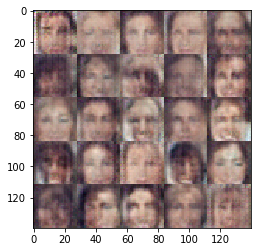

Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 0.7210
Epoch 1/1... Discriminator Loss: 1.2256... Generator Loss: 1.1596
Epoch 1/1... Discriminator Loss: 1.3619... Generator Loss: 0.7919
Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.9894
Epoch 1/1... Discriminator Loss: 1.1852... Generator Loss: 0.8986
Epoch 1/1... Discriminator Loss: 1.3568... Generator Loss: 0.6892
Epoch 1/1... Discriminator Loss: 1.3648... Generator Loss: 0.7096
Epoch 1/1... Discriminator Loss: 1.1759... Generator Loss: 0.9544
Epoch 1/1... Discriminator Loss: 1.3242... Generator Loss: 1.2614
Epoch 1/1... Discriminator Loss: 1.4698... Generator Loss: 0.5795


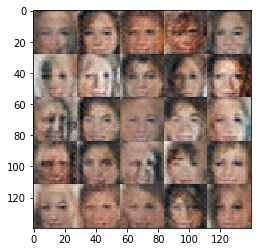

Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.7620
Epoch 1/1... Discriminator Loss: 1.1623... Generator Loss: 1.0758
Epoch 1/1... Discriminator Loss: 1.3531... Generator Loss: 0.6307
Epoch 1/1... Discriminator Loss: 1.4377... Generator Loss: 0.7924
Epoch 1/1... Discriminator Loss: 1.3733... Generator Loss: 0.7706
Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.9035
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.9878
Epoch 1/1... Discriminator Loss: 1.4688... Generator Loss: 0.5818
Epoch 1/1... Discriminator Loss: 1.2602... Generator Loss: 0.9692
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.7334


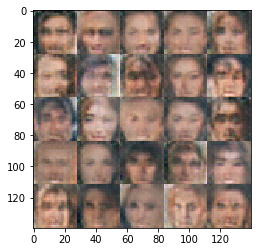

Epoch 1/1... Discriminator Loss: 1.3478... Generator Loss: 0.6617
Epoch 1/1... Discriminator Loss: 1.3518... Generator Loss: 0.6457
Epoch 1/1... Discriminator Loss: 1.2657... Generator Loss: 1.0082
Epoch 1/1... Discriminator Loss: 1.3195... Generator Loss: 0.7421
Epoch 1/1... Discriminator Loss: 1.3447... Generator Loss: 1.0095
Epoch 1/1... Discriminator Loss: 1.3174... Generator Loss: 0.7700
Epoch 1/1... Discriminator Loss: 1.2816... Generator Loss: 0.8675
Epoch 1/1... Discriminator Loss: 1.5620... Generator Loss: 0.7905
Epoch 1/1... Discriminator Loss: 1.2143... Generator Loss: 1.0151
Epoch 1/1... Discriminator Loss: 1.2860... Generator Loss: 0.7893


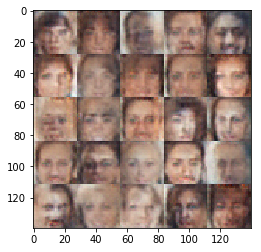

Epoch 1/1... Discriminator Loss: 1.3621... Generator Loss: 0.8775
Epoch 1/1... Discriminator Loss: 1.4321... Generator Loss: 0.5450
Epoch 1/1... Discriminator Loss: 1.3190... Generator Loss: 0.9782
Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.7439
Epoch 1/1... Discriminator Loss: 1.5650... Generator Loss: 0.4973
Epoch 1/1... Discriminator Loss: 1.2458... Generator Loss: 0.9481
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.6246
Epoch 1/1... Discriminator Loss: 1.4663... Generator Loss: 0.8937
Epoch 1/1... Discriminator Loss: 1.1838... Generator Loss: 0.8106
Epoch 1/1... Discriminator Loss: 1.4210... Generator Loss: 0.6521


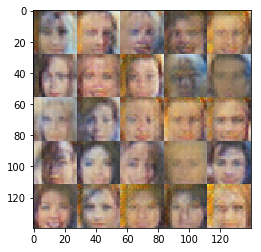

Epoch 1/1... Discriminator Loss: 1.2451... Generator Loss: 0.7929
Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 0.7351
Epoch 1/1... Discriminator Loss: 1.2885... Generator Loss: 1.0202
Epoch 1/1... Discriminator Loss: 1.3441... Generator Loss: 0.8415
Epoch 1/1... Discriminator Loss: 1.2987... Generator Loss: 0.6623
Epoch 1/1... Discriminator Loss: 1.3707... Generator Loss: 0.6827
Epoch 1/1... Discriminator Loss: 1.4573... Generator Loss: 0.9629
Epoch 1/1... Discriminator Loss: 1.4002... Generator Loss: 0.7046
Epoch 1/1... Discriminator Loss: 1.3243... Generator Loss: 0.7932
Epoch 1/1... Discriminator Loss: 1.4703... Generator Loss: 0.5801


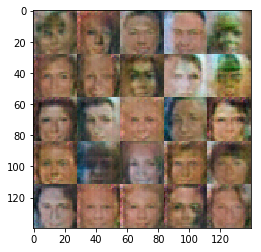

Epoch 1/1... Discriminator Loss: 1.4595... Generator Loss: 0.5984
Epoch 1/1... Discriminator Loss: 1.3041... Generator Loss: 0.9514
Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 0.8259
Epoch 1/1... Discriminator Loss: 1.5532... Generator Loss: 0.5674
Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 0.6593
Epoch 1/1... Discriminator Loss: 1.3320... Generator Loss: 0.7651
Epoch 1/1... Discriminator Loss: 1.5593... Generator Loss: 0.5109
Epoch 1/1... Discriminator Loss: 1.3525... Generator Loss: 0.9056
Epoch 1/1... Discriminator Loss: 1.3097... Generator Loss: 0.8728
Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.6283


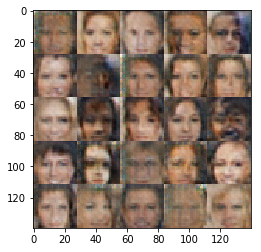

Epoch 1/1... Discriminator Loss: 1.3216... Generator Loss: 0.7631
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.7992
Epoch 1/1... Discriminator Loss: 1.3700... Generator Loss: 0.6304
Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.7328
Epoch 1/1... Discriminator Loss: 1.4229... Generator Loss: 0.8995
Epoch 1/1... Discriminator Loss: 1.2290... Generator Loss: 0.8253
Epoch 1/1... Discriminator Loss: 1.2870... Generator Loss: 0.9913
Epoch 1/1... Discriminator Loss: 1.2904... Generator Loss: 0.9440
Epoch 1/1... Discriminator Loss: 1.2641... Generator Loss: 0.9683
Epoch 1/1... Discriminator Loss: 1.2788... Generator Loss: 0.9870


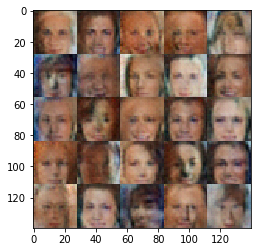

Epoch 1/1... Discriminator Loss: 1.2621... Generator Loss: 0.9555
Epoch 1/1... Discriminator Loss: 1.2956... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 1.4690... Generator Loss: 0.9483
Epoch 1/1... Discriminator Loss: 1.4181... Generator Loss: 0.6085
Epoch 1/1... Discriminator Loss: 1.2936... Generator Loss: 0.7988
Epoch 1/1... Discriminator Loss: 1.3200... Generator Loss: 0.8833
Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 0.6741
Epoch 1/1... Discriminator Loss: 1.3788... Generator Loss: 0.7988
Epoch 1/1... Discriminator Loss: 1.6278... Generator Loss: 0.8342
Epoch 1/1... Discriminator Loss: 1.2741... Generator Loss: 0.9547


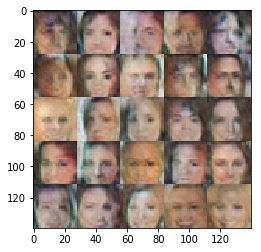

Epoch 1/1... Discriminator Loss: 1.5130... Generator Loss: 0.5235
Epoch 1/1... Discriminator Loss: 1.3149... Generator Loss: 0.8492
Epoch 1/1... Discriminator Loss: 1.3652... Generator Loss: 0.8294
Epoch 1/1... Discriminator Loss: 1.3238... Generator Loss: 0.7114
Epoch 1/1... Discriminator Loss: 1.3182... Generator Loss: 0.9377
Epoch 1/1... Discriminator Loss: 1.2567... Generator Loss: 0.8864
Epoch 1/1... Discriminator Loss: 1.4056... Generator Loss: 0.7358
Epoch 1/1... Discriminator Loss: 1.3566... Generator Loss: 0.8587
Epoch 1/1... Discriminator Loss: 1.4556... Generator Loss: 0.5735
Epoch 1/1... Discriminator Loss: 1.3276... Generator Loss: 0.8742


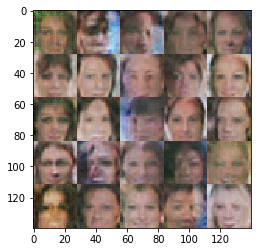

Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 0.7930
Epoch 1/1... Discriminator Loss: 1.4236... Generator Loss: 0.7039
Epoch 1/1... Discriminator Loss: 1.4561... Generator Loss: 0.6376
Epoch 1/1... Discriminator Loss: 1.2480... Generator Loss: 0.8304
Epoch 1/1... Discriminator Loss: 1.3630... Generator Loss: 1.0175
Epoch 1/1... Discriminator Loss: 1.2866... Generator Loss: 0.8143
Epoch 1/1... Discriminator Loss: 1.4360... Generator Loss: 0.6898
Epoch 1/1... Discriminator Loss: 1.3860... Generator Loss: 0.8450
Epoch 1/1... Discriminator Loss: 1.3719... Generator Loss: 1.0306
Epoch 1/1... Discriminator Loss: 1.4006... Generator Loss: 0.8270


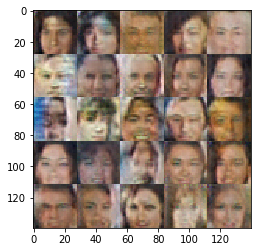

Epoch 1/1... Discriminator Loss: 1.2615... Generator Loss: 1.0065
Epoch 1/1... Discriminator Loss: 1.2141... Generator Loss: 0.8934
Epoch 1/1... Discriminator Loss: 1.4976... Generator Loss: 0.5371
Epoch 1/1... Discriminator Loss: 1.3069... Generator Loss: 0.5994
Epoch 1/1... Discriminator Loss: 1.3811... Generator Loss: 0.5468
Epoch 1/1... Discriminator Loss: 1.3501... Generator Loss: 0.6714
Epoch 1/1... Discriminator Loss: 1.3642... Generator Loss: 0.6792
Epoch 1/1... Discriminator Loss: 1.3047... Generator Loss: 0.8169
Epoch 1/1... Discriminator Loss: 1.4372... Generator Loss: 0.6076
Epoch 1/1... Discriminator Loss: 1.3299... Generator Loss: 1.0834


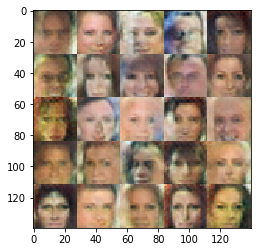

Epoch 1/1... Discriminator Loss: 1.2346... Generator Loss: 0.7772
Epoch 1/1... Discriminator Loss: 1.2960... Generator Loss: 0.8946
Epoch 1/1... Discriminator Loss: 1.2257... Generator Loss: 1.0826
Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.9551
Epoch 1/1... Discriminator Loss: 1.4148... Generator Loss: 0.5432
Epoch 1/1... Discriminator Loss: 1.3285... Generator Loss: 0.9238
Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 0.9266
Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 0.7249
Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.7614
Epoch 1/1... Discriminator Loss: 1.1964... Generator Loss: 0.9245


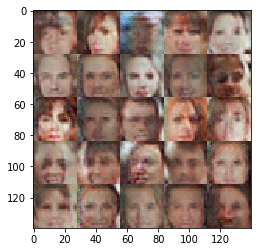

Epoch 1/1... Discriminator Loss: 1.4220... Generator Loss: 0.6165
Epoch 1/1... Discriminator Loss: 1.2296... Generator Loss: 0.8774
Epoch 1/1... Discriminator Loss: 1.3544... Generator Loss: 0.7925
Epoch 1/1... Discriminator Loss: 1.3645... Generator Loss: 0.7931
Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 1.0906
Epoch 1/1... Discriminator Loss: 1.2976... Generator Loss: 0.6441
Epoch 1/1... Discriminator Loss: 1.2392... Generator Loss: 1.0459
Epoch 1/1... Discriminator Loss: 1.3496... Generator Loss: 0.7803
Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.8653
Epoch 1/1... Discriminator Loss: 1.2309... Generator Loss: 0.8592


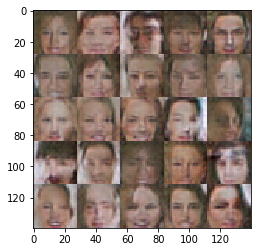

Epoch 1/1... Discriminator Loss: 1.3138... Generator Loss: 0.7345
Epoch 1/1... Discriminator Loss: 1.3422... Generator Loss: 0.7605
Epoch 1/1... Discriminator Loss: 1.4418... Generator Loss: 0.8134
Epoch 1/1... Discriminator Loss: 1.2453... Generator Loss: 0.8377
Epoch 1/1... Discriminator Loss: 1.4795... Generator Loss: 0.7005
Epoch 1/1... Discriminator Loss: 1.3290... Generator Loss: 1.0122
Epoch 1/1... Discriminator Loss: 1.4395... Generator Loss: 0.5112
Epoch 1/1... Discriminator Loss: 1.3272... Generator Loss: 0.8046
Epoch 1/1... Discriminator Loss: 1.3016... Generator Loss: 0.8636
Epoch 1/1... Discriminator Loss: 1.4830... Generator Loss: 0.6618


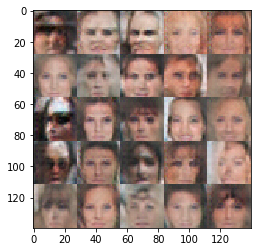

Epoch 1/1... Discriminator Loss: 1.3456... Generator Loss: 0.7019
Epoch 1/1... Discriminator Loss: 1.2637... Generator Loss: 0.9548
Epoch 1/1... Discriminator Loss: 1.4788... Generator Loss: 0.4878
Epoch 1/1... Discriminator Loss: 1.1813... Generator Loss: 0.9134
Epoch 1/1... Discriminator Loss: 1.3208... Generator Loss: 0.6898
Epoch 1/1... Discriminator Loss: 1.3544... Generator Loss: 0.7954


IndexError: list index out of range

In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.